In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
import statsmodels.api as sm
from sklearn import linear_model

We need to import our data (training and test sets are already split)

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

Lets get a feel for what our data looks like. 

In [3]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Off the bat, we see a large amount of columns and NaN values. Lets see which
columns contain missing data. 

In [4]:
train_data.isnull().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
LotFrontage       259
GarageCond         81
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageQual         81
BsmtExposure       38
BsmtFinType2       38
BsmtFinType1       37
BsmtCond           37
BsmtQual           37
MasVnrArea          8
MasVnrType          8
Electrical          1
Utilities           0
YearRemodAdd        0
MSSubClass          0
Foundation          0
ExterCond           0
ExterQual           0
Exterior2nd         0
Exterior1st         0
RoofMatl            0
RoofStyle           0
YearBuilt           0
                 ... 
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
3SsnPorch           0
BsmtUnfSF           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
Functional          0
TotRmsAbvGrd        0
KitchenQua

19 columns contain missing data. But is it really "missing"? If we take a look
at the columns, all of the attributes listed may be missing in any given house.
It is entirely possible that a house does not have an alley, masonry veneer,
basement, fireplace, garage, pool, fence, or misc features. That being said, the lack of
these features may affect house prices, so we should replace the NaN's with
"None" for categorical columns, and replace the NaN's with zeros for numerical
columns  

In [5]:
train_data['PoolQC'] = train_data['PoolQC'].fillna('None')
train_data['Alley'] = train_data['Alley'].fillna('None')
train_data['Fence'] = train_data['Fence'].fillna('None')
train_data['MiscFeature'] = train_data['MiscFeature'].fillna('None')
train_data['FireplaceQu'] = train_data['FireplaceQu'].fillna('None')
train_data['GarageType'] = train_data['GarageType'].fillna('None')
train_data['GarageCond'] = train_data['GarageCond'].fillna('None')
train_data['GarageFinish'] = train_data['GarageFinish'].fillna('None')
train_data['GarageQual'] = train_data['GarageQual'].fillna('None')
train_data['GarageYrBlt'] = train_data['GarageYrBlt'].fillna(0)
train_data['BsmtQual'] = train_data['BsmtQual'].fillna('None')
train_data['BsmtCond'] = train_data['BsmtCond'].fillna('None')
train_data['BsmtExposure'] = train_data['BsmtExposure'].fillna('None')
train_data['BsmtFinType1'] = train_data['BsmtFinType1'].fillna('None')
train_data['BsmtFinType2'] = train_data['BsmtFinType2'].fillna('None')
train_data['MasVnrArea'] = train_data['MasVnrArea'].fillna(0)
train_data['MasVnrType'] = train_data['MasVnrType'].fillna('None')

That takes care of 17/19 columns. Two attributes that I did not mention were lot frontage and electrical. The 
lot frontage column is described as "linear feet of street connected to property."
and electrical is the type of electrical system. 

The electrical column is missing a single datapoint. 
A single missing datapoint is not enough to warrant a prediction. We will just
delete this row. 

In [6]:
train_data = train_data.dropna(subset=['Electrical']).reset_index(drop=True)

Now I want to look at lot frontage. There are 259 missing data points for this 
variable. First, lets check if lot frontage is at all useful to predicting house prices.

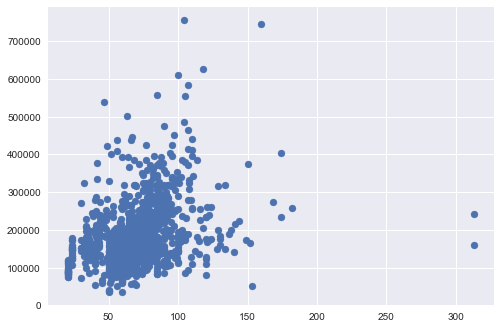

The correlation coefficient is 0.35


In [7]:
plt.scatter(x='LotFrontage',y='SalePrice',data=train_data)
plt.show()
print('The correlation coefficient is', np.round(train_data['LotFrontage'].corr(train_data['SalePrice']),2))

It really doesn't seem that lot frontage affects the home price. For now, let's just
delete that column. I will also drop the Id column because that has no impact
on house prices.

In [8]:
train_data = train_data.drop(['LotFrontage'],axis=1)
train_data = train_data.drop(['Id'],axis=1)

Now lets confirm we have got rid of all NaN values. 

In [9]:
train_data.isnull().sum().sort_values(ascending=False)

SalePrice       0
BsmtQual        0
Exterior1st     0
Exterior2nd     0
MasVnrType      0
MasVnrArea      0
ExterQual       0
ExterCond       0
Foundation      0
BsmtCond        0
RoofStyle       0
BsmtExposure    0
BsmtFinType1    0
BsmtFinSF1      0
BsmtFinType2    0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
RoofMatl        0
YearRemodAdd    0
HeatingQC       0
LotConfig       0
MSZoning        0
LotArea         0
Street          0
Alley           0
LotShape        0
LandContour     0
Utilities       0
LandSlope       0
               ..
PoolArea        0
GarageCars      0
PoolQC          0
Fence           0
MiscFeature     0
MiscVal         0
MoSold          0
YrSold          0
SaleType        0
GarageArea      0
GarageFinish    0
Electrical      0
HalfBath        0
1stFlrSF        0
2ndFlrSF        0
LowQualFinSF    0
GrLivArea       0
BsmtFullBath    0
BsmtHalfBath    0
FullBath        0
BedroomAbvGr    0
GarageYrBlt     0
KitchenAbvGr    0
KitchenQual     0
TotRmsAbvG

We have transformed our data to get rid of non-integers, so now we can do some exploratory analysis.
Lets take a look at the variable we will predict, sale price. 

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


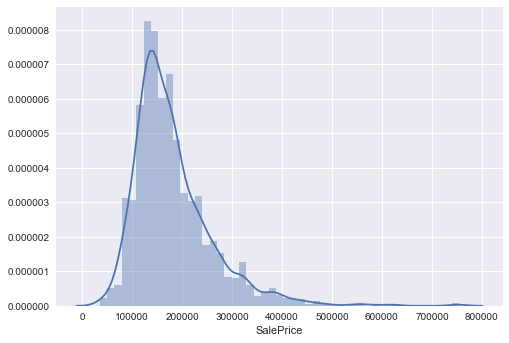

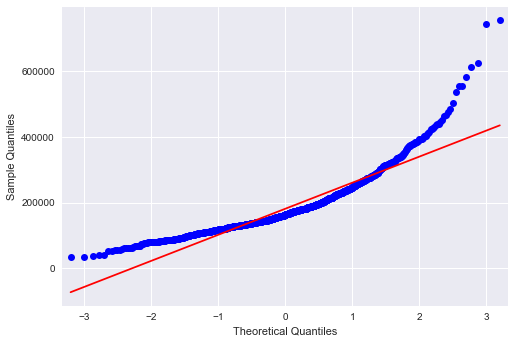

In [10]:
sns.distplot(train_data['SalePrice'])
plt.show()

sm.qqplot(train_data['SalePrice'],line='s')
plt.show()

The data is right-skewed. I think linear models in this case could work, but we 
need to log transform the data. 

In [11]:
train_data['SalePrice'] = np.log(train_data['SalePrice'])

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


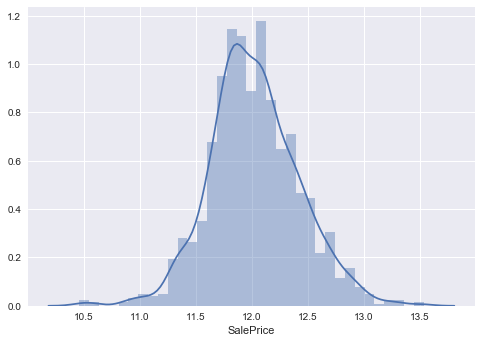

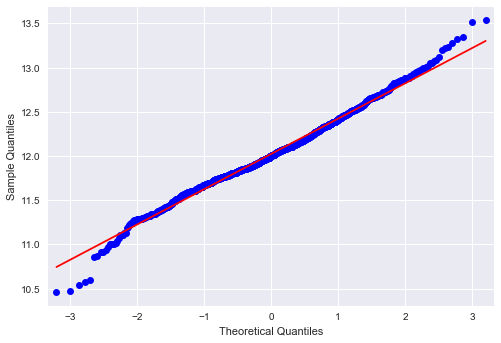

In [13]:
sns.distplot(train_data['SalePrice'])
plt.show()

sm.qqplot(train_data['SalePrice'],line='s')
plt.show()

Much better! The data is now normally distributed, and we can work with linear
models. Before anything, we first we need to convert our categorical columns to a number
in order for the algorithms to proceed. 

In [14]:
for i in train_data.columns:
    if train_data[i].dtype == np.object:
        train_data[i] = train_data[i].astype('category')
        train_data[i] = train_data[i].cat.codes

Provide similar transformations to the test set. I need to save the Id column
before deleting it so I can upload results to Kaggle. 

In [15]:
for i in test_data.columns:
    if test_data[i].dtype == np.object:
        test_data[i] = test_data[i].fillna('None')
        test_data[i] = test_data[i].astype('category')
        test_data[i] = test_data[i].cat.codes
    elif test_data[i].dtype == np.int64 or test_data[i].dtype == np.float64:
        test_data[i] = test_data[i].fillna(0)

In [16]:
test_data = test_data.drop(['LotFrontage'],axis=1)
test_id = test_data['Id']
test_data = test_data.drop(['Id'],axis=1)

I tried out a bunch of linear models to see which gave the best score on Kaggle, and it seems like Lasso LARS gave the best results. LARS, which stands for Least-angle regression, is an algorithm to fit linear regression models to high-dimensional data. We are utilizing ~80 columns, which is a lot of dimensions. 

In [17]:
Lasso_LARS = linear_model.LassoLarsCV()

Note that I use LassoLarsCV instead of just LassoLars. CV, or cross-validation, is utilized to find the optimal alpha parameter.

Now, we need to split the data into X and Y variables (also makes it easier to type out)

In [19]:
X_train = train_data[train_data.columns.difference(['SalePrice'])]
Y_train = train_data['SalePrice']

X_test = test_data[test_data.columns.difference(['SalePrice'])]

Need to standardize the data in order for the algorithm to work. This makes
each individual feature have a mean of 0 and a standard deviation of 1. The L1
or L2 regularizers of linear models assume that all features are centered around 0. 

In [22]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Now we can fit our model. 

In [23]:
Lasso_LARS.fit(X_train, Y_train)

LassoLarsCV(copy_X=True, cv=None, eps=2.2204460492503131e-16,
      fit_intercept=True, max_iter=500, max_n_alphas=1000, n_jobs=1,
      normalize=True, positive=False, precompute='auto', verbose=False)

Our model is complete, and now we can calculate the final predictions using the test data. Note that we must take the exponential of the predictions since we log-transformed our data early on. 

In [25]:
pred = np.e**Lasso_LARS.predict(X_test)

In [26]:
pred

array([ 116939.56377647,  159727.03706977,  167938.42419156, ...,
        159076.84993691,  113705.51706622,  243822.92800223])

After uploading our results to Kaggle, the RMSLE (RMS log-error) was 0.13289, which is good enough for ~1,400/3500 place on the leaderboards. Most legitimate scores are around 0.11 so I'm quite happy with the results. I could probably improve this score a bit using xgboost, but this will do for now. 